# VWAP Reversion Strategy
This notebook implements a VWAP Reversion Strategy for 5-min or 15-min charts. The strategy is ideal for choppy days or when news causes spikes.

## Strategy Description
1. Stock moves sharply away from VWAP and forms a reversal candle (e.g., hammer, doji).
2. Enter a trade back toward the VWAP.
3. Stop Loss: Candle high/low.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Function to calculate VWAP
def calculate_vwap(data):
    data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
    return data

In [19]:
# Function to identify reversal candles
def identify_reversal_candles(data):
    data['Reversal'] = ((data['Close'] > data['Open']) & 
                        ((data['High'] - data['Close']) > 2 * (data['Close'] - data['Open']))) | \
                       ((data['Open'] > data['Close']) & 
                        ((data['Open'] - data['Low']) > 2 * (data['Open'] - data['Close'])))
    return data

/var/folders/xm/xpjbh6gs4wbd230qlkym3xqh0000gn/T/ipykernel_2421/537246728.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('data/RELIANCE_1m.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))


Data shape after filtering for the last month: (10000, 7)
                 Date        Open        High         Low       Close  \
0 2008-01-01 00:00:00  660.605408  662.662659  648.056152  651.062012   
1 2008-01-01 00:01:00  660.599852  662.660278  648.052374  651.064155   
2 2008-01-01 00:02:00  660.594296  662.657897  648.048596  651.066298   
3 2008-01-01 00:03:00  660.588740  662.655515  648.044818  651.068441   
4 2008-01-01 00:04:00  660.583184  662.653134  648.041041  651.070584   

    Adj Close        Volume  
0  576.367920  5.270274e+06  
1  576.369817  5.276085e+06  
2  576.371714  5.281896e+06  
3  576.373611  5.287707e+06  
4  576.375509  5.293518e+06  


/var/folders/xm/xpjbh6gs4wbd230qlkym3xqh0000gn/T/ipykernel_2421/537246728.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_5min = data.resample('5T').agg({


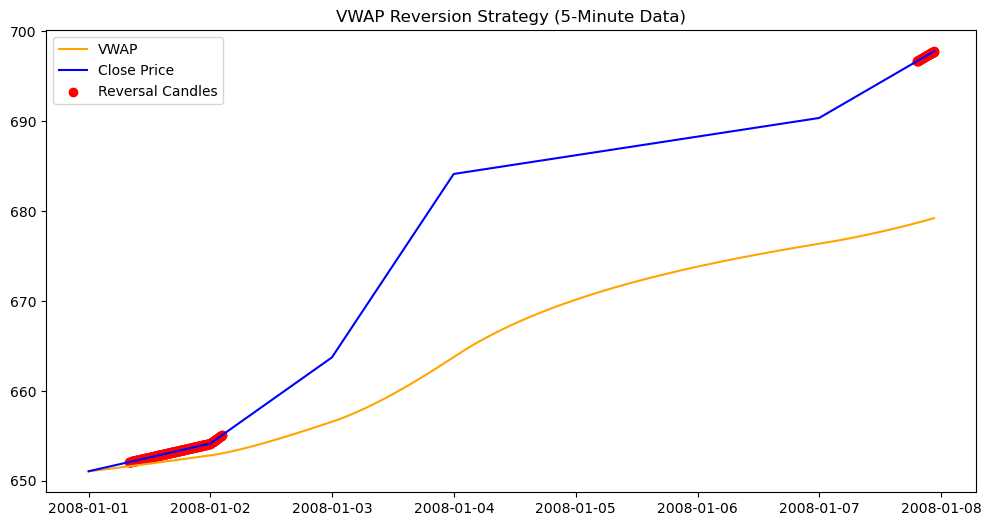

        Entry Datetime  Entry Price  Exit Price       Exit Datetime   Return%
0  2008-01-01 08:00:00   652.099209  652.120639 2008-01-01 08:10:00  0.003286
1  2008-01-01 08:15:00   652.131354  652.152783 2008-01-01 08:25:00  0.003286
2  2008-01-01 08:30:00   652.163498  652.184928 2008-01-01 08:40:00  0.003286
3  2008-01-01 08:45:00   652.195643  652.217072 2008-01-01 08:55:00  0.003286
4  2008-01-01 09:00:00   652.227787  652.249217 2008-01-01 09:10:00  0.003286
..                 ...          ...         ...                 ...       ...
83 2008-01-07 21:25:00   697.417031  697.471637 2008-01-07 21:35:00  0.007830
84 2008-01-07 21:40:00   697.498940  697.553545 2008-01-07 21:50:00  0.007829
85 2008-01-07 21:55:00   697.580848  697.635454 2008-01-07 22:05:00  0.007828
86 2008-01-07 22:10:00   697.662757  697.717362 2008-01-07 22:20:00  0.007827
87 2008-01-07 22:25:00   697.744665  697.799271 2008-01-07 22:35:00  0.007826

[88 rows x 5 columns]


In [22]:
# Example usage
# Read only 1 month of data from the CSV file
data = pd.read_csv('data/RELIANCE_1m.csv', parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
# Keep only the first 10,000 rows from the CSV file
data = data.head(1000)
print(f"Data shape after filtering for the last month: {data.shape}")
print(data.head())

# Aggregating 1-minute data to 5-minute intervals
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data_5min = data.resample('5T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum'
}).dropna()

# Use the aggregated data for VWAP calculation and strategy
data_5min = calculate_vwap(data_5min)
data_5min = identify_reversal_candles(data_5min)

# Plot the aggregated data
plt.figure(figsize=(12, 6))
plt.plot(data_5min['VWAP'], label='VWAP', color='orange')
plt.plot(data_5min['Close'], label='Close Price', color='blue')
# Fixing the ValueError by aligning indices for scatter plot
reversal_points = data_5min[data_5min['Reversal']]
plt.scatter(reversal_points.index, reversal_points['Close'], label='Reversal Candles', color='red', marker='o')
plt.legend()
plt.title('VWAP Reversion Strategy (5-Minute Data)')
plt.show()

# Backtesting function
# Enhanced backtesting logic to address repetitive entries and exits
def backtest_strategy(data, min_holding_period=2):
    trades = []
    in_trade = False  # Track if a trade is active
    entry_index = None

    for i in range(1, len(data)):
        if not in_trade and data['Reversal'].iloc[i]:
            # Entry condition: Reversal candle
            entry_price = data['Close'].iloc[i]
            entry_datetime = data.index[i]
            entry_index = i
            in_trade = True

        elif in_trade and (i - entry_index) >= min_holding_period:
            # Exit condition: Price returns to VWAP after minimum holding period
            if data['Close'].iloc[i] >= data['VWAP'].iloc[i]:
                exit_price = data['Close'].iloc[i]
                exit_datetime = data.index[i]
                return_pct = ((exit_price - entry_price) / entry_price) * 100

                trades.append({
                    'Entry Datetime': entry_datetime,
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'Exit Datetime': exit_datetime,
                    'Return%': return_pct
                })

                in_trade = False  # Reset trade status

    return pd.DataFrame(trades)

# Example usage
# Assuming data_5min is already prepared as per the earlier code
backtest_results = backtest_strategy(data_5min)
print(backtest_results)

In [ ]:
# Plot entry and exit markers on the VWAP chart
plt.figure(figsize=(12, 6))
plt.plot(data_5min['VWAP'], label='VWAP', color='orange')
plt.plot(data_5min['Close'], label='Close Price', color='blue')
# Plot reversal points
plt.scatter(reversal_points.index, reversal_points['Close'], label='Reversal Candles', color='red', marker='o')
# Plot entry and exit points
for _, trade in backtest_results.iterrows():
    plt.scatter(trade['Entry Datetime'], trade['Entry Price'], color='green', label='Entry', marker='^')
    plt.scatter(trade['Exit Datetime'], trade['Exit Price'], color='purple', label='Exit', marker='v')
plt.legend()
plt.title('VWAP Reversion Strategy with Entry and Exit Markers')
plt.show()